In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load IMDB datasets

In [2]:
#Load the datasets
IMDB_title = pd.read_csv('IMDB/title.basics.tsv',sep='\t', low_memory=False)
IMDB_ratings = pd.read_csv('IMDB/title.ratings.tsv', sep = '\t')

In [3]:
display(IMDB_ratings)

,tconst,averageRating,numVotes
0,tt0000001,5.7,2005
1,tt0000002,5.8,269
2,tt0000003,6.5,1908
3,tt0000004,5.5,178
4,tt0000005,6.2,2688
...,...,...,...
1366964,tt9916730,7.6,11
1366965,tt9916766,7.0,22
1366966,tt9916778,7.2,36
1366967,tt9916840,8.8,6


In [4]:
display(IMDB_title)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10295872,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10295873,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10295874,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10295875,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


## Preprocess IMDB datasets

In [5]:
# only choose the rows which correspond to data of a movie
IMDB_title = IMDB_title[IMDB_title['titleType'] == 'movie']

In [6]:
#merge the dataset with the titles and the dataset with the ratings
df_IMDB = IMDB_title.merge(IMDB_ratings, left_on='tconst', right_on='tconst')
display(df_IMDB)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,207
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.3,484
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.1,15
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,855
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.0,21
...,...,...,...,...,...,...,...,...,...,...,...
299653,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,\N,84,Thriller,5.8,1448
299654,tt9916362,movie,Coven,Akelarre,0,2020,\N,92,"Drama,History",6.4,5605
299655,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,\N,\N,"Adventure,History,War",3.5,17
299656,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,\N,123,Drama,8.6,7


Let's check if there are aberrant values in the averageRating column, for example negative values or values higher than 10.

In [7]:
df_IMDB.describe()

,averageRating,numVotes
count,299658.000000,2.996580e+05
mean,6.175995,3.619263e+03
std,1.370387,3.570741e+04
min,1.000000,5.000000e+00
25%,5.300000,1.900000e+01
50%,6.300000,6.100000e+01
75%,7.100000,3.130000e+02
max,10.000000,2.816055e+06


There are no aberrant values in the averageRating column.

We want to have the average rating of each movie. In df_IMDB, we have several ratings for each movies; indeed, the same movie (characterized by its 'orginialTitle') have a grade for each 'primaryTitle' used.
In the calculation of the average rating per originalTitle, we will ponderate the rating per primaryTitle with the number of votes per primaryTitle.
Then, we will calculate the average rating across all primaryTitle i for an originalTitle as :  
$Average\, Rating\, of\, originalTitle =\frac{\sum {average\,rating\,of\,primaryTitle(i) \times number\,of\,votes\,of\,primaryTitle(i)}} {\sum{number\,of\,votes\,of\,primaryTitle(i)}}$


In [9]:
#create datasets of average ratings of a movie considering the ratings of movies with titles in different language


#Calculate average_rating_language(i) * number_of_votes_language(i) (ponderate)
df_IMDB['mult_ratings'] = df_IMDB['averageRating']*df_IMDB['numVotes']

average_ratings = pd.DataFrame()
average_ratings['sum_of_mult_ratings'] = df_IMDB[['originalTitle', 'mult_ratings']].groupby('originalTitle').sum()
average_ratings['total_vote'] = df_IMDB[['originalTitle', 'numVotes']].groupby('originalTitle').sum()
average_ratings['total_average_rating'] = average_ratings['sum_of_mult_ratings']/average_ratings['total_vote']

average_ratings = average_ratings.reset_index(level=0)

#Create a new dataframe with the movies primary titles, release years, and average ratings.
MovieRatings = df_IMDB.merge(average_ratings[['total_average_rating', 'originalTitle', 'total_vote']], how = 'left', on = 'originalTitle')
MovieRatings=MovieRatings[['primaryTitle', 'startYear', 'total_average_rating', 'total_vote']]
MovieRatings=MovieRatings.drop_duplicates(subset=['primaryTitle', 'startYear' ])

#Prepare the dataset to be merged with CMU movies.
MovieRatings= MovieRatings.rename(columns = {"primaryTitle" : "MovieName", "startYear" : "ReleaseYear", "total_average_rating" : "AverageRating", "total_vote" : "NumberofVotes"})
MovieRatings["ReleaseYear"]=pd.to_datetime(MovieRatings["ReleaseYear"], errors='coerce').dt.year

display(MovieRatings)

,MovieName,ReleaseYear,AverageRating,NumberofVotes
0,Miss Jerry,1894.0,5.300000,207
1,The Corbett-Fitzsimmons Fight,1897.0,5.300000,484
2,Bohemios,1905.0,4.285714,28
3,The Story of the Kelly Gang,1906.0,6.000000,855
4,The Prodigal Son,1907.0,5.036364,33
...,...,...,...,...
299652,Safeguard,2020.0,3.700000,245
299653,Il talento del calabrone,2020.0,5.800000,1448
299655,The Secret of China,2019.0,3.500000,17
299656,Kuambil Lagi Hatiku,2019.0,8.600000,7


## Merge with CMU Movie dataset

In [10]:
movies_CMU = pd.read_csv('movies_preprocessed.tsv', sep = '\t')

In [11]:
display(movies_CMU)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},"{""/m/07s9rl0"": ""Drama""}",1983.0
...,...,...,...,...,...,...,...,...,...,...
53585,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{""/m/07s9rl0"": ""Drama""}",2011.0
53586,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,{'/m/02h40lc': 'English Language'},"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011.0
53587,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972.0
53588,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992.0


In [12]:
df_ratings = movies_CMU.merge(MovieRatings, on=["MovieName", "ReleaseYear"], how='left' )
display(df_ratings)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear,AverageRating,NumberofVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,4.9,56894.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,5.6,40.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0,NaN,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},"{""/m/07s9rl0"": ""Drama""}",1983.0,5.9,623.0
...,...,...,...,...,...,...,...,...,...,...,...,...
53585,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{""/m/07s9rl0"": ""Drama""}",2011.0,NaN,NaN
53586,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,{'/m/02h40lc': 'English Language'},"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011.0,6.8,3193.0
53587,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972.0,5.8,111.0
53588,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992.0,NaN,NaN


## Analysis of final dataset

In [13]:
print('Percentage of missing entries in the testdataset:\n', 100*df_ratings[['AverageRating']].isna().sum() / len(df_ratings))

Percentage of missing entries in the testdataset:
 AverageRating    37.262549
dtype: float64


In [14]:
missing_data_per_year = df_ratings.groupby('ReleaseYear')['AverageRating'].agg(total='size', missing=lambda x: x.isna().sum()).reset_index()
missing_data_per_year['percentage_missing'] = (missing_data_per_year['missing'] / missing_data_per_year['total']) * 100
display(missing_data_per_year)

,ReleaseYear,total,missing,percentage_missing
0,1912.0,11,8,72.727273
1,1913.0,17,8,47.058824
2,1914.0,33,14,42.424242
3,1915.0,45,24,53.333333
4,1916.0,76,38,50.000000
...,...,...,...,...
96,2008.0,1908,825,43.238994
97,2009.0,1767,704,39.841539
98,2010.0,1490,580,38.926174
99,2011.0,1275,443,34.745098


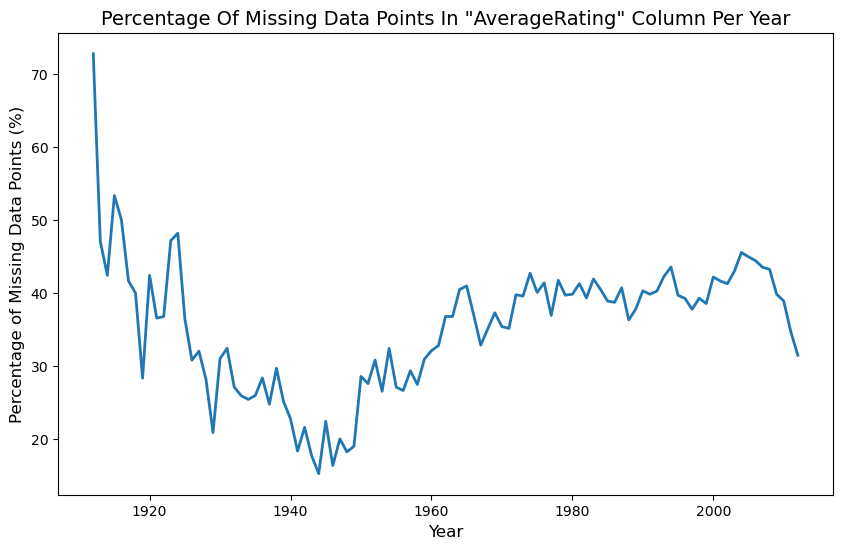

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(missing_data_per_year['ReleaseYear'], missing_data_per_year['percentage_missing'], linestyle='-', linewidth=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage of Missing Data Points (%)', fontsize=12)
plt.title('Percentage Of Missing Data Points In "AverageRating" Column Per Year', fontsize=14)
plt.show()

## Export the file

In [17]:
output_file = "Ratings_PreProcessed.tsv"
df_ratings.to_csv(output_file, sep='\t', index=False)